<a href="https://colab.research.google.com/github/MarieTKD/support2/blob/main/classification_support2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Study of the Support 2 dataset

##Research question <br>
How well do different machine learning classifiers perform in predicting mortality in hospitalized patients?


In [ ]:
pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

###Load the data and visualization

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
support2 = fetch_ucirepo(id=880)

# data (as pandas dataframes)
X = support2.data.features
y = support2.data.targets

# metadata
print(support2.metadata)

# variable information
print(support2.variables)


{'uci_id': 880, 'name': 'SUPPORT2', 'repository_url': 'https://archive.ics.uci.edu/dataset/880/support2', 'data_url': 'https://archive.ics.uci.edu/static/public/880/data.csv', 'abstract': "This dataset comprises 9105 individual critically ill patients across 5 United States medical centers, accessioned throughout 1989-1991 and 1992-1994.\nEach row concerns hospitalized patient records who met the inclusion and exclusion criteria for nine disease categories: acute respiratory failure, chronic obstructive pulmonary disease, congestive heart failure, liver disease, coma, colon cancer, lung cancer, multiple organ system failure with malignancy, and multiple organ system failure with sepsis. The goal is to determine these patients' 2- and 6-month survival rates based on several physiologic, demographics, and disease severity information. \nIt is an important problem because it addresses the growing national concern over patients' loss of control near the end of life. It enables earlier deci

"This dataset comprises 9105 individual critically ill patients across 5 United States medical centers, accessioned throughout 1989-1991 and 1992-1994. Each row concerns hospitalized patient records who met the inclusion and exclusion criteria for nine disease categories: acute respiratory failure, chronic obstructive pulmonary disease, congestive heart failure, liver disease, coma, colon cancer, lung cancer, multiple organ system failure with malignancy, and multiple organ system failure with sepsis. The goal is to determine these patients' 2- and 6-month survival rates based on several physiologic, demographics, and disease severity information. It is an important problem because it addresses the growing national concern over patients' loss of control near the end of life. It enables earlier decisions and planning to reduce the frequency of a mechanical, painful, and prolonged dying process."<br>
University Department of Biostatistics, Professor Frank Harrell 2022, url: https://hbiostat.org/data/

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       9105 non-null   float64
 1   sex       9105 non-null   object 
 2   dzgroup   9105 non-null   object 
 3   dzclass   9105 non-null   object 
 4   num.co    9105 non-null   int64  
 5   edu       7471 non-null   float64
 6   income    6123 non-null   object 
 7   scoma     9104 non-null   float64
 8   charges   8933 non-null   float64
 9   totcst    8217 non-null   float64
 10  totmcst   5630 non-null   float64
 11  avtisst   9023 non-null   float64
 12  race      9063 non-null   object 
 13  sps       9104 non-null   float64
 14  aps       9104 non-null   float64
 15  surv2m    9104 non-null   float64
 16  surv6m    9104 non-null   float64
 17  hday      9105 non-null   int64  
 18  diabetes  9105 non-null   int64  
 19  dementia  9105 non-null   int64  
 20  ca        9105 non-null   obje

We have a mix of categorical and numerical (continuous and discrete) data. 42 features but some may not be needed for this study. 9105 rows with quite a few missing data. We'll have to handle this. We also have some data type objects. These will probably need some modifications.

Let's look at the dnr column, for example. The different answers are 'no dnr', 'dnr after sadm', 'dnr before sadm', and missing values. If we want to use this column, we'll have to encode the values as maybe 0:'no dnr', 1: 'dnr before or after sadm'.

In [ ]:
X['dnr'].unique()

array(['no dnr', nan, 'dnr after sadm', 'dnr before sadm'], dtype=object)

In this dataset, we have three targets: death, hospdead, and sfdm2. We will use the column 'death' as our target. Patients are recorded as dead (1) if they either died at the hospital or were discharged alive but found in the NDI before 1995. If a patient was discharged alive and not found in the NDI before 1995, they are assumed to be alive (0).

In [ ]:
y.head()

,death,hospdead,sfdm2
0,0,0,NaN
1,1,1,<2 mo. follow-up
2,1,0,<2 mo. follow-up
3,1,0,no(M2 and SIP pres)
4,0,0,no(M2 and SIP pres)


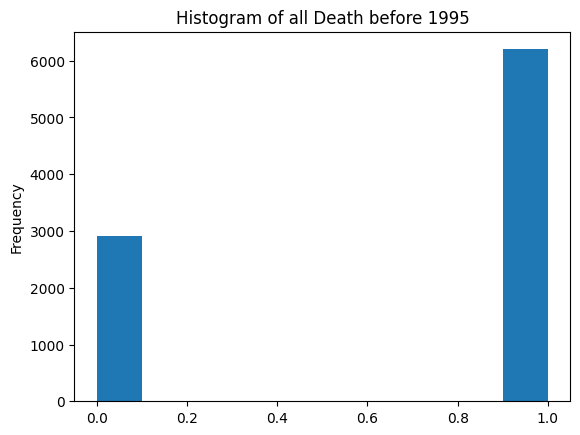

In [ ]:
plt.hist(y['death'])
plt.ylabel('Frequency')
plt.title('Histogram of all Death before 1995')
plt.show()


In [ ]:
X.describe()

,age,num.co,edu,scoma,charges,totcst,totmcst,avtisst,sps,aps,...,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
count,9105.000000,9105.000000,7471.000000,9104.000000,8.933000e+03,8217.000000,5630.000000,9023.000000,9104.000000,9104.000000,...,6504.000000,9038.000000,9104.000000,6821.000000,4605.000000,4753.000000,4243.000000,3464.000000,6238.000000,9105.000000
mean,62.650823,1.868644,11.747691,12.058546,5.999579e+04,30825.867768,28828.877838,22.610928,25.525872,37.597979,...,2.554463,1.770961,137.568541,7.415364,159.873398,32.349463,2191.546047,1.157910,1.637384,1.888272
std,15.593710,1.344409,3.447743,24.636694,1.026488e+05,45780.820986,43604.261932,13.233248,9.899377,19.903852,...,5.318448,1.686041,6.029326,0.080563,88.391541,26.792288,1455.245777,1.739672,2.231358,2.003763
min,18.041990,0.000000,0.000000,0.000000,1.169000e+03,0.000000,-102.719970,1.000000,0.199982,0.000000,...,0.099991,0.099991,110.000000,6.829102,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,52.797000,1.000000,10.000000,0.000000,9.740000e+03,5929.566400,5177.404300,12.000000,19.000000,23.000000,...,0.500000,0.899902,134.000000,7.379883,103.000000,14.000000,1165.500000,0.000000,0.000000,0.000000
50%,64.856990,2.000000,12.000000,0.000000,2.502400e+04,14452.734400,13223.500000,19.500000,23.898438,34.000000,...,0.899902,1.199951,137.000000,7.419922,135.000000,23.000000,1968.000000,0.000000,1.000000,1.000000
75%,73.998960,3.000000,14.000000,9.000000,6.459800e+04,36087.937500,34223.601600,31.666656,30.199219,49.000000,...,1.899902,1.899902,141.000000,7.469727,188.000000,42.000000,3000.000000,2.000000,3.000000,3.000000
max,101.847960,9.000000,31.000000,100.000000,1.435423e+06,633212.000000,710682.000000,83.000000,99.187500,143.000000,...,63.000000,21.500000,181.000000,7.769531,1092.000000,300.000000,9000.000000,7.000000,7.000000,7.073242


In [ ]:
y.describe()

,death,hospdead
count,9105.000000,9105.000000
mean,0.681054,0.259198
std,0.466094,0.438219
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


Let's drop the 2 targets that we won't use:

In [ ]:
y = y.drop(["hospdead", "sfdm2"], axis=1)
y.head()

,death
0,0
1,1
2,1
3,1
4,0


Let's take a look at some of the features to have an idea of the repartition of the population studied: age, sex, dzgroup and race.

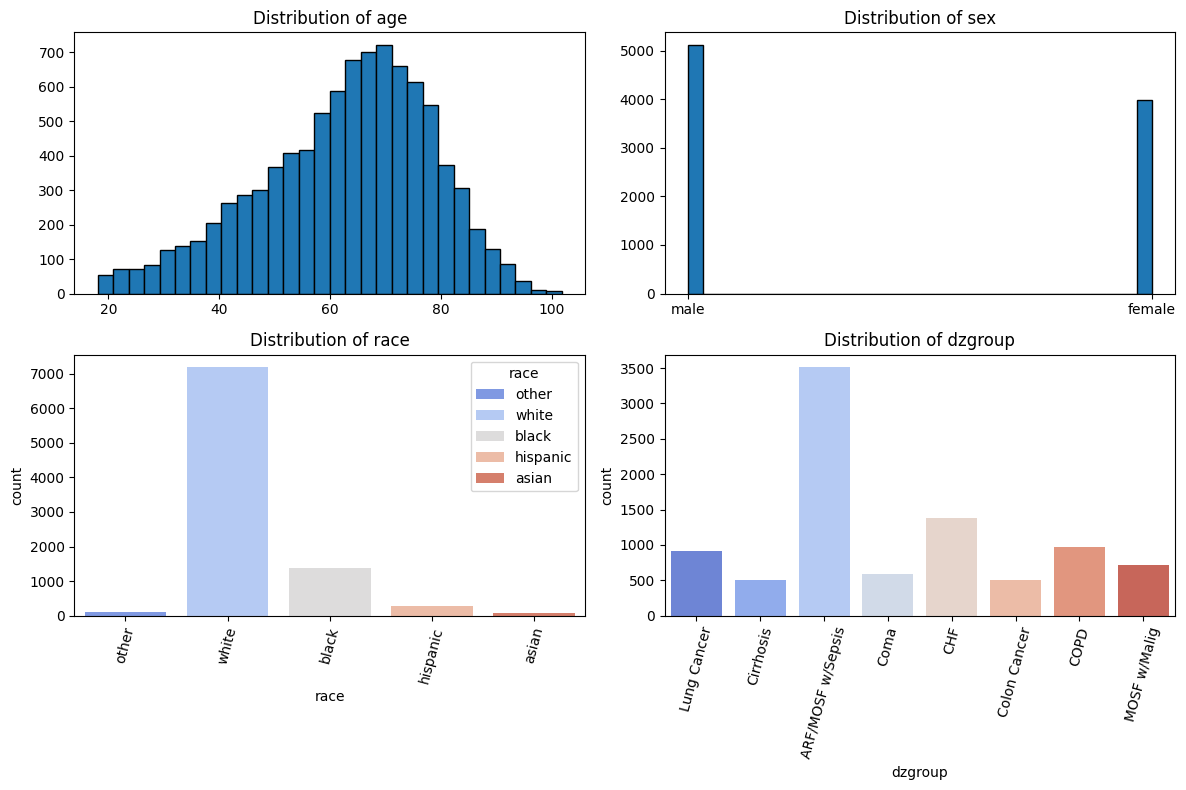

In [ ]:
features = ['age', 'sex']
cat_feat = ['race', 'dzgroup']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Histograms ploting
for i, feature in enumerate(features):
    row, col = divmod(i, 2)  # Get row and column index
    axes[row, col].hist(X[feature], bins=30, edgecolor='black')
    axes[row, col].set_title(f"Distribution of {feature}")

for i, feature in enumerate(cat_feat):
    row, col = divmod(i + len(features), 2)  # Adjust index for 2nd row
    sns.countplot(x=X[feature], ax=axes[row, col], palette='coolwarm', hue=X[feature])
    axes[row, col].set_title(f"Count of {feature}")
    axes[row, col].tick_params(axis='x', rotation=75)
    axes[row, col].set_title(f"Distribution of {feature}")

# Adjust layout for better readability
plt.tight_layout()
plt.show()

We can see that the repartition of the patients by age is pretty symetrical around 70 years old, with slightly more males than females. A vast majority of the patients were White, and the most prominent group of disease was kidney or multiple organs failure with sepsis (ARF/MOSF w/Sepsis)

###Data preprocessing

In [ ]:
X.isna().sum()

,0
age,0
sex,0
dzgroup,0
dzclass,0
num.co,0
edu,1634
income,2982
scoma,1
charges,172
totcst,888


Some columns have a lot of NAs.
The doctors who created the dataset gave this recommendations to deal with missing values:
Baseline Variable	Normal Fill-in Value
- Serum albumin (alb)	3.5
- PaO2/FiO2 ratio (pafi) 	333.3
- Bilirubin (bili)	1.01
- Creatinine (crea)	1.01
- bun	6.51
- White blood count (wblc)	9 (thousands)
- Urine output (urine)	2502

I will use these numbers to fill-in the missing values then remove the rows with the leftover missing values.

In [ ]:
# Replacing NAs with recommended values
X.loc[X['alb'].isna(), 'alb'] = 3.5
X.loc[X['pafi'].isna(), 'pafi'] = 333.3
X.loc[X['bili'].isna(), 'bili'] = 1.01
X.loc[X['crea'].isna(), 'crea'] = 1.01
X.loc[X['bun'].isna(), 'bun'] = 6.51
X.loc[X['wblc'].isna(), 'wblc'] = 9000
X.loc[X['urine'].isna(), 'urine'] = 2502


Some columns have a large number of missing values, as shown in the percentage of NAs below. We can drop the columns adlp (62% of NAs), glucose(50% of NAs), income, adls and ph because they are missing too many informations.<br>
Some feature are not interesting for our research question, like costs variables (totmcst, totcst, charges) and anything related to DNR (dnr, dnrday). Income and education also have a lot of missing values (33%, 18% respectively) and shouldn't be relevant for our study. <br>
Survival estimates at 2 and 6 months (prg2m, prg6m, surv2m, surv6m) also have missing values and may give too much information to the model.<br>
dzclass and dzgroup are redundant features. We'll drop dzclass since dzgroup carries more information that could be interesting.

In [ ]:
missing_percent = X.isna().sum() / len(X) * 100
missing_percent.sort_values(ascending=False)

,0
adlp,61.954970
glucose,49.423394
totmcst,38.165843
income,32.751236
adls,31.488193
ph,25.085118
prg2m,18.110928
edu,17.946183
prg6m,17.935200
totcst,9.752883


In [ ]:
X_opt = X.drop(['adlp', 'glucose', 'totmcst', 'income', 'edu', 'adls', 'ph', 'prg2m', 'prg6m', 'surv2m', 'surv6m', 'dnr', 'dnrday', 'totmcst', 'totcst', 'charges', 'dzclass'], axis=1)
X_opt.head()

,age,sex,dzgroup,num.co,scoma,avtisst,race,sps,aps,hday,...,resp,temp,pafi,alb,bili,crea,sod,bun,urine,adlsc
0,62.84998,male,Lung Cancer,0,0.0,7.000000,other,33.898438,20.0,1,...,22.0,36.00000,388.00000,1.799805,0.199982,1.199951,141.0,6.51,2502.0,7.0
1,60.33899,female,Cirrhosis,2,44.0,29.000000,white,52.695312,74.0,3,...,34.0,34.59375,98.00000,3.500000,1.010000,5.500000,132.0,6.51,2502.0,1.0
2,52.74698,female,Cirrhosis,2,0.0,13.000000,white,20.500000,45.0,4,...,28.0,37.39844,231.65625,3.500000,2.199707,2.000000,134.0,6.51,2502.0,0.0
3,42.38498,female,Lung Cancer,2,0.0,7.000000,white,20.097656,19.0,1,...,32.0,35.00000,333.30000,3.500000,1.010000,0.799927,139.0,6.51,2502.0,0.0
4,79.88495,female,ARF/MOSF w/Sepsis,1,26.0,18.666656,white,23.500000,30.0,3,...,20.0,37.89844,173.31250,3.500000,1.010000,0.799927,143.0,6.51,2502.0,2.0


Now that we are down to 26 features, we can drop the NAs and encode the categorical features: sex, dzgroup, race and ca.

In [ ]:
X_opt.dropna(inplace=True)

categorical_features = X_opt.select_dtypes(include=['object', 'category']).columns

# Encoder initialization
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Transform categorical features
encoded_array = encoder.fit_transform(X_opt[categorical_features])

# Convert to a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features), index=X_opt.index)

# Restructure X_opt
X_opt = X_opt.drop(columns=categorical_features)
X_opt = pd.concat([X_opt, encoded_df], axis=1)
X_opt.head()

,age,num.co,scoma,avtisst,sps,aps,hday,diabetes,dementia,meanbp,...,dzgroup_Colon Cancer,dzgroup_Coma,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes
0,62.84998,0,0.0,7.000000,33.898438,20.0,1,0,0,97.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,60.33899,2,44.0,29.000000,52.695312,74.0,3,0,0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,52.74698,2,0.0,13.000000,20.500000,45.0,4,0,0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,42.38498,2,0.0,7.000000,20.097656,19.0,1,0,0,75.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,79.88495,1,26.0,18.666656,23.500000,30.0,3,0,0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Let's now take a look at the correlation matrix.

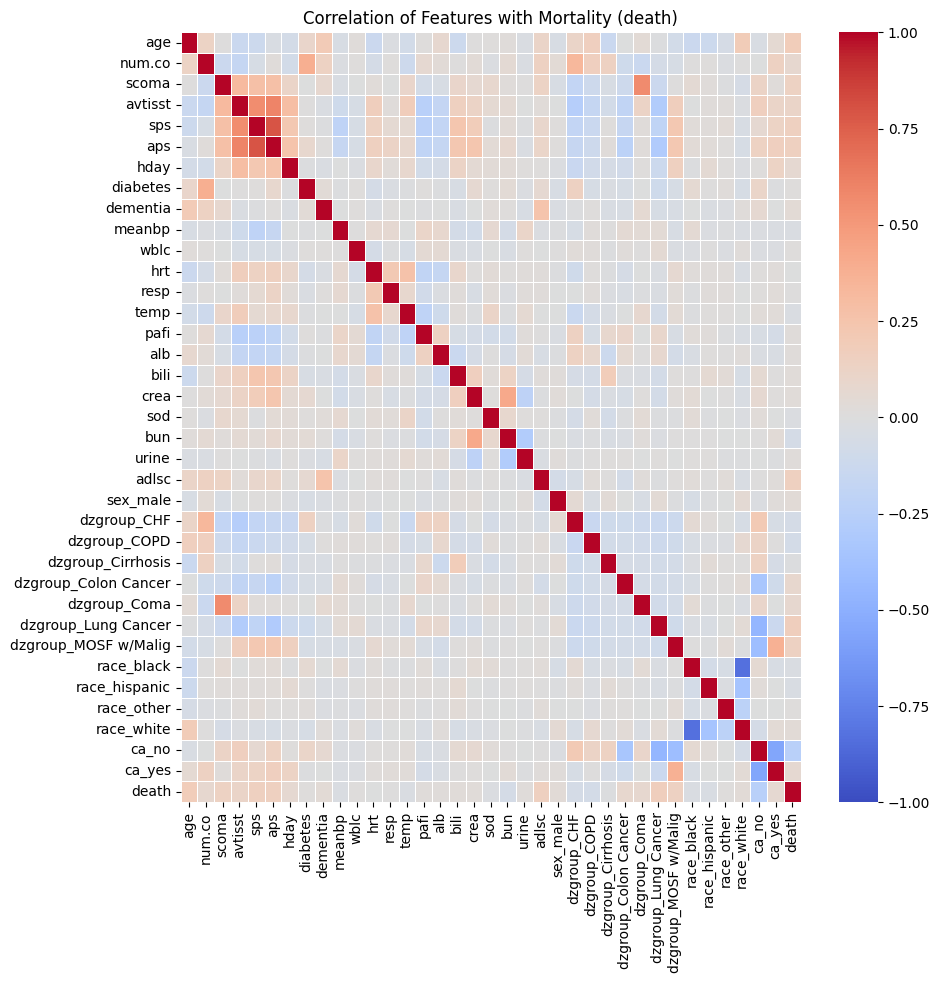

In [ ]:
# Adding the target to X_opt for correlation
df = X_opt.copy()
df['death'] = y

correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation of Features with Mortality (death)")
plt.show()

There isn't any problem of collinearity. There is a correlation between sps and aps (both physiology scores) because of redundancy. We'll drop sps which is generated from Support data.

In [ ]:
X_opt.drop(['sps'], axis=1)

,age,num.co,scoma,avtisst,aps,hday,diabetes,dementia,meanbp,wblc,...,dzgroup_Colon Cancer,dzgroup_Coma,dzgroup_Lung Cancer,dzgroup_MOSF w/Malig,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes
0,62.84998,0,0.0,7.000000,20.0,1,0,0,97.0,6.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,60.33899,2,44.0,29.000000,74.0,3,0,0,43.0,17.097656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,52.74698,2,0.0,13.000000,45.0,4,0,0,70.0,8.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,42.38498,2,0.0,7.000000,19.0,1,0,0,75.0,9.099609,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,79.88495,1,26.0,18.666656,30.0,3,0,0,59.0,13.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,66.07300,1,0.0,20.333328,22.0,13,0,0,109.0,7.399414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9101,55.15399,1,41.0,18.000000,31.0,1,0,0,43.0,9000.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9102,70.38196,1,0.0,23.000000,39.0,18,0,0,111.0,8.398438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9103,47.01999,1,0.0,35.500000,51.0,22,0,0,99.0,7.599609,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


Now we can finish cleaning the dataset by removing the missing values.

In [ ]:
df.dropna(inplace=True)
X = df.drop(['death'], axis=1)
y = df['death']

##Analysis using KNN, SVM and Random Forest

Note: I will directly use scikit-learn to train the models instead of the more complex version in the homeworks.

In [ ]:
# Divide training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

###KNN analysis

In [ ]:
# Scaling the data. This will be reused for the SVM model
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Let's try to fit the data with 5 neighbors and the ballTree algorithm since we have more than 20 features.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='ball_tree')

In [ ]:
# Predictions and accuracy for the training set:
y_pred_train = knn.predict(X_train_sc)
accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy on training set:", accuracy)

Accuracy on training set: 0.8012249443207127


The accuracy is 0.8, let's see if we gain more accuracy by changing the number of neighbors k between 1 and 15.

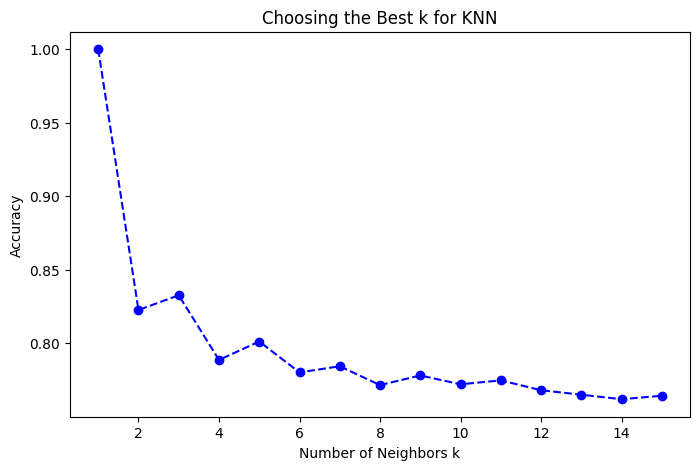

In [ ]:
acc_by_k = []

# Looping through k values
for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree')
    knn.fit(X_train_sc, y_train)
    y_pred_train = knn.predict(X_train_sc)
    accuracy = accuracy_score(y_train, y_pred_train)
    acc_by_k.append(accuracy)

plt.figure(figsize=(8,5))
plt.plot(range(1, 16), acc_by_k, marker='o', linestyle='dashed', color='blue')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Accuracy')
plt.title('Choosing the Best k for KNN')
plt.show()

It looks like k=3 would be a good fit. Let's rerun the model with k=3 and try on the test set.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree')
knn.fit(X_train_sc, y_train)
y_pred_train = knn.predict(X_train_sc)
accuracy = accuracy_score(y_train, y_pred_train)
print("KNN accuracy on training set:", accuracy)

KNN accuracy on training set: 0.8326837416481069


In [ ]:
# Results on test set
y_pred_test = knn.predict(X_test_sc)
accuracy = accuracy_score(y_test, y_pred_test)
print("KNN accuracy on testing set:", accuracy)

KNN accuracy on testing set: 0.6887527839643652


The model k=3 performs well on the training set but the test set isn't as accurate. It might be overfitting. Let's go back to k=5 and see if the test set gets more accurate, then we'll look at the confusion matrix for more details.

In [ ]:
knn5 = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
knn5.fit(X_train_sc, y_train)
y_pred_test = knn5.predict(X_test_sc)
knn_accuracy = accuracy_score(y_test, y_pred_test)
print("KNN accuracy on testing set:", knn_accuracy)

KNN accuracy on testing set: 0.7071269487750557


<Figure size 600x400 with 0 Axes>

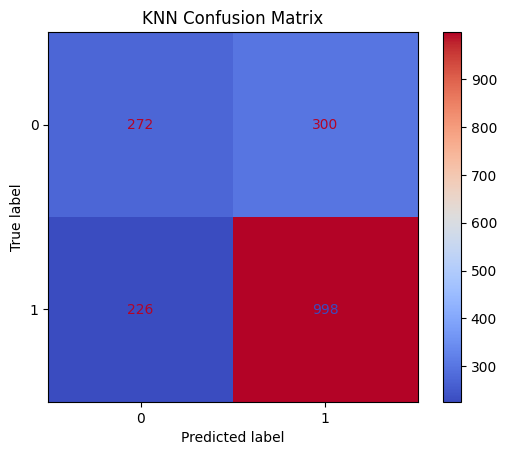

In [ ]:
# Using the test set to visualise the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='coolwarm')
plt.title("KNN Confusion Matrix")
plt.show()

This model seems better at predicting the death category, and is a lot more confused about survival. Let's try a different model to see if we can improve the result: Support Vector Machine.

###SVM

In [ ]:
# We use the scaled X: X_train_sc and X_test_sc previously generated to train the model

clf = SVC(kernel='linear', C=1)  # We may need to tune C
clf.fit(X_train_sc, y_train)
y_pred_train = clf.predict(X_train_sc)
accuracy = accuracy_score(y_train, y_pred_train)
print("SVM accuracy on training set:", accuracy)

SVM accuracy on training set: 0.7575167037861915


The accuracy isn't as good as the KNN model. Let's try different values of C

In [ ]:
acc_by_C = []

# Looping through C values
for c in [1, 10, 20]:
    clf = SVC(kernel='linear', C=c)
    clf.fit(X_train_sc, y_train)
    y_pred_train = clf.predict(X_train_sc)
    accuracy = accuracy_score(y_train, y_pred_train)
    acc_by_C.append(accuracy)

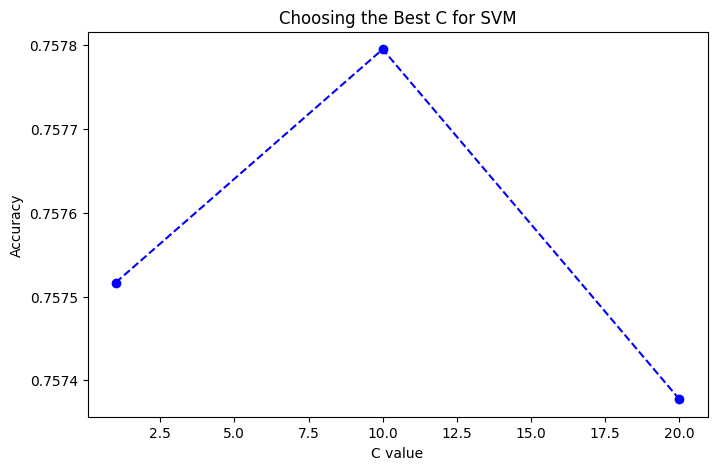

In [ ]:
plt.figure(figsize=(8,5))
plt.plot([1,10,20], acc_by_C, marker='o', linestyle='dashed', color='blue')
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('Choosing the Best C for SVM')
plt.show()

Modifying C doesn't help... Let's try a different kernel instead.

In [ ]:
# Fitting with radial basis function
clf= SVC(C=1.0, kernel='rbf', gamma=1.0).fit(X_train_sc,y_train)
y_pred_train = clf.predict(X_train_sc)
accuracy = accuracy_score(y_train, y_pred_train)
print("SVM (rbf) accuracy on training set:", accuracy)

SVM (rbf) accuracy on training set: 0.9994432071269488


An accuracy of 99.9% could be good news but it can also be a model too complex that is overfitting. Let's try to use GridSearch to find the best parameters C and gamma.

In [ ]:
# GridSearch for C and gamma values (time consumming)
C_values = [0.1, 1, 10]
gamma_values = [0.01, 0.1, 1]
g_search = GridSearchCV(estimator=SVC(), param_grid = {'C': C_values, 'gamma': gamma_values} , cv=3)
g_search.fit(X,y)
g_search.best_params_

{'C': 0.1, 'gamma': 0.01}

In [ ]:
# Fitting classifier with g_search results
best_clf = SVC(C=0.1, kernel='rbf', gamma=0.01).fit(X_train_sc,y_train)
y_pred_train = best_clf.predict(X_train_sc)
accuracy = accuracy_score(y_train, y_pred_train)
print("SVM (rbf) accuracy on training set:", accuracy)

y_pred_test = best_clf.predict(X_test_sc)
svm_accuracy = accuracy_score(y_test, y_pred_test)
print("SVM (rbf) accuracy on test set:", svm_accuracy)

SVM (rbf) accuracy on training set: 0.7398385300668151
SVM (rbf) accuracy on test set: 0.7422048997772829


Let's take a look at the confusion matrix for best_clf.

<Figure size 600x400 with 0 Axes>

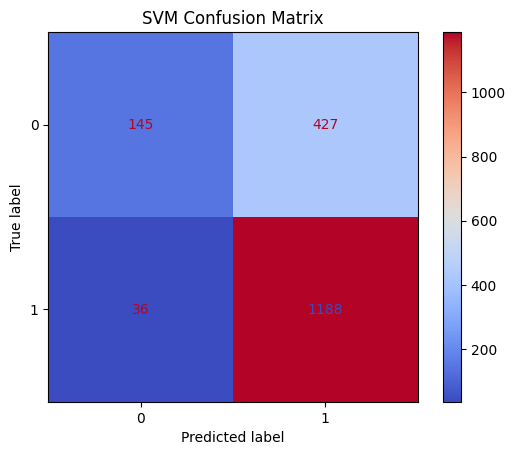

In [ ]:
# Using the test set to visualise the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='coolwarm')
plt.title("SVM Confusion Matrix")
plt.show()

We get better results with SVM than with KNN. The SVM seems especially good at categorising death correctly, but its performance with survival is worse than KNN. Next, we'll try the Random Forest model.

###Random Forest

We don't need to scale the X for Random Forest models so we'll use X_train and X_test.

In [ ]:
# Fit model with 100 trees and bas parameters
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_train = rf_clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
print("Random Forest accuracy on training set:", accuracy)

Random Forest accuracy on training set: 1.0


The training set accuracy shows overfitting. Let's try to tune the model to improve that. First we can limit the max_depth of the tree.

In [ ]:
# Max_depth = 10
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_train = rf_clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
print("Random Forest accuracy on training set:", accuracy)

Random Forest accuracy on training set: 0.8396436525612472


In [ ]:
y_pred_test = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_test)
print("Random Forest accuracy on test set:", rf_accuracy)

Random Forest accuracy on test set: 0.7678173719376392


<Figure size 600x400 with 0 Axes>

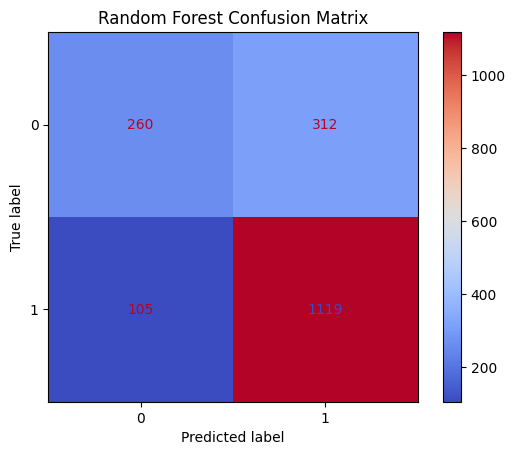

In [ ]:
# Using the test set to visualise the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='coolwarm')
plt.title("Random Forest Confusion Matrix")
plt.show()

##Conclusion

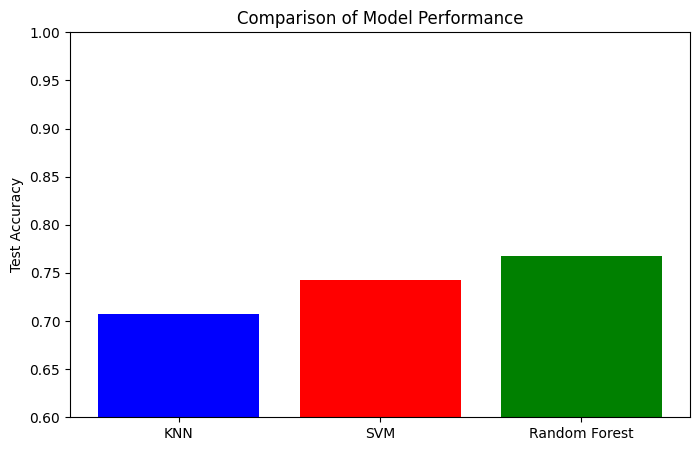

In [ ]:
model_names = ["KNN", "SVM", "Random Forest"]
accuracies = [knn_accuracy, svm_accuracy, rf_accuracy]

plt.figure(figsize=(8,5))
plt.bar(model_names, accuracies, color=['blue', 'red', 'green'])
plt.ylim(0.6, 1)
plt.ylabel("Test Accuracy")
plt.title("Comparison of Model Performance")
plt.show()


The three models tested: KNN, SVM, and Random Forest, are doing a decent job predicting the death of the patients: around 73%. Of the models, the Random Forest is the best, followed by SVM and KNN. The models were better at classifying death than survival, maybe because of the class imbalance.<br>
KNN suffered from the high dimensionality of the data. SVM deals with dimensionality better but is not as performant as a Random Forest model with 100 trees!<br>
Some additional data preprocessing might help, removing more features for example, as well as different methods like boosting.